http://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader

In [2]:
badBomDF = spark.read.csv('data/nsw_temp.csv', inferSchema='True', header=True)

In [3]:
badBomDF.printSchema()

root
 |-- Product code: string (nullable = true)
 |-- Bureau of Meteorology station number: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Maximum temperature (Degree C): double (nullable = true)
 |-- Days of accumulation of maximum temperature: integer (nullable = true)
 |-- Quality: string (nullable = true)



In [4]:
#badBomDF.groupBy().avg('Maximum temperature (Degree C)')

In [5]:
%%sh

head -n 5 data/nsw_temp.csv

grep "Maximum temperature" data/nsw_temp.csv | wc -l

Product code,Bureau of Meteorology station number,Year,Month,Day,Maximum temperature (Degree C),Days of accumulation of maximum temperature,Quality
IDCJAC0010,061087,1965,01,01,25.6,,Y
IDCJAC0010,061087,1965,01,02,32.2,1,Y
IDCJAC0010,061087,1965,01,03,23.1,1,Y
IDCJAC0010,061087,1965,01,04,25.6,1,Y
      41


In [6]:
%%sh

rm -rf 'output/nsw_temp.csv'

In [7]:
sc.textFile('data/nsw_temp.csv').filter(lambda l:l.startswith('IDC')).saveAsTextFile('output/nsw_temp.csv')

In [8]:
bomDF = spark.createDataFrame(spark.read.csv('output/nsw_temp.csv', inferSchema='True', header=False).rdd, 
        schema = ['product_id', 'station_id', 'year', 'month', 'day', 'max_temp', 'days_of_acc', 'quality'])
bomDF.cache()

bomDF.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- station_id: long (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- day: long (nullable = true)
 |-- max_temp: double (nullable = true)
 |-- days_of_acc: long (nullable = true)
 |-- quality: string (nullable = true)



In [9]:
bomDF.groupBy().avg('max_temp')

,avg(max_temp)
0,22.812952


In [10]:
bomDF.select('year').distinct().count()

155

In [11]:
bomDF.groupBy('year').count().sort('year')

,year,count
0,1859,365
1,1860,366
2,1861,365
3,1862,365
4,1863,365
5,1864,366
6,1865,365
7,1866,365
8,1867,365
9,1868,366


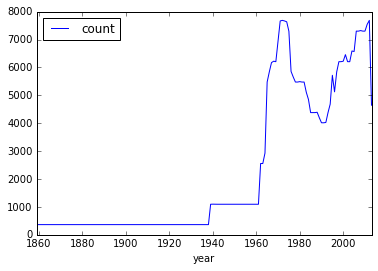

In [12]:
bomDF.groupBy('year').count().sort('year').toPandas().set_index('year').plot()

In [13]:
from pyspark.sql.functions import *
bomDF.groupBy('station_id').count().sort(desc('count')).limit(1)

,station_id,count
0,66062,56470


In [14]:
bomDF.where(col('station_id') == 66062).groupBy('year') \
    .agg(avg('max_temp').alias('avg_max_temp'), stddev('max_temp').alias('sd_max_temp')).sort('year')

,year,avg_max_temp,sd_max_temp
0,1859,21.399452,4.969578
1,1860,20.276986,4.398397
2,1861,20.864658,5.248745
3,1862,21.353151,5.001068
4,1863,20.959178,4.812610
5,1864,20.579452,4.493890
6,1865,21.692033,5.060305
7,1866,21.217808,4.552186
8,1867,21.784658,4.663134
9,1868,21.434247,4.553522


In [15]:
tempByStationAndMonth = bomDF.where((col('year') > 1990) &  (col('year')< 2001)) \
    .groupBy(col('station_id'), col('month')) \
    .agg(avg('max_temp').alias('avg_max_temp'), stddev('max_temp').alias('sd_max_temp')) \
    .sort(col('station_id'), col('month'))
tempByStationAndMonth

,station_id,month,avg_max_temp,sd_max_temp
0,61087,1,27.644565,4.273773
1,61087,2,28.143529,3.948642
2,61087,3,26.774725,3.939729
3,61087,4,22.905747,2.935522
4,61087,5,20.463636,2.364560
5,61087,6,17.726496,2.084193
6,61087,7,17.274790,1.876221
7,61087,8,18.809016,2.402444
8,61087,9,21.751724,3.838715
9,61087,10,23.865000,4.516536


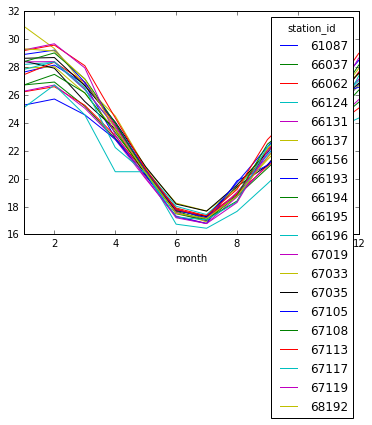

In [16]:
import pandas as pd
tempByStationAndMonthPD = tempByStationAndMonth.toPandas()
tempByStationAndMonthPD.set_index(['month', 'station_id']).unstack()['avg_max_temp'].plot()

### Unknow values

In [37]:
print(bomDF.count())
bomDF.dropna().count()
bomDF.na.replace()

352696


,product_id,station_id,year,month,day,max_temp,days_of_acc,quality
0,IDCJAC0010,61087,1965,1,1,25.6,0,Y
1,IDCJAC0010,61087,1965,1,2,32.2,1,Y
2,IDCJAC0010,61087,1965,1,3,23.1,1,Y
3,IDCJAC0010,61087,1965,1,4,25.6,1,Y
4,IDCJAC0010,61087,1965,1,5,26.7,1,Y
5,IDCJAC0010,61087,1965,1,6,25.3,1,Y
6,IDCJAC0010,61087,1965,1,7,20.3,1,Y
7,IDCJAC0010,61087,1965,1,8,22.5,1,Y
8,IDCJAC0010,61087,1965,1,9,24.2,1,Y
9,IDCJAC0010,61087,1965,1,10,28.6,1,Y


### UDF

In [29]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

uncertanity = udf(lambda temp, quality: temp * (0.1 if quality == 'Y' else 0.3) if temp is not None else None 
                  , DoubleType())

In [30]:
bomDF.select(uncertanity(col('max_temp'), col('quality')))

,"<lambda>(max_temp, quality)"
0,2.56
1,3.22
2,2.31
3,2.56
4,2.67
5,2.53
6,2.03
7,2.25
8,2.42
9,2.86


### Windows


[Introduction to Window Functions](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html)


In [53]:
from pyspark.sql import Window
bomWithDateDF = bomDF.withColumn('date', to_date(format_string("%04d-%02d-%02d", col('year'), col('month'), col('day'))))        

TypeError: _() takes no arguments (1 given)

In [79]:
bomRankDF = bomWithDateDF.dropna().select(col('date'), col('station_id'), col('max_temp'),  rank() \
            .over(Window.partitionBy(col('date')).orderBy(desc('max_temp')) \
                     .rowsBetween(Window.unboundedPreceding, Window.currentRow)).alias('rank')) \
    .where(col('year')==2000).sort('date', 'rank', 'station_id')

display(bomRankDF.limit(10))

,date,station_id,max_temp,rank
0,2000-01-01,67113,23.4,1
1,2000-01-01,68192,23.0,2
2,2000-01-01,67035,22.9,3
3,2000-01-01,67108,22.4,4
4,2000-01-01,67119,22.3,5
5,2000-01-01,67105,22.0,6
6,2000-01-01,67117,22.0,6
7,2000-01-01,67019,21.9,8
8,2000-01-01,66137,21.8,9
9,2000-01-01,66194,21.5,10


In [86]:
hotestStationDF = bomRankDF.where(col('rank') == 1).groupBy('station_id').count().sort(desc('count'))
display(hotestStationDF)

,station_id,count
0,67113,149
1,61087,43
2,67035,43
3,66037,29
4,66062,29
5,67105,26
6,66195,22
7,66124,19
8,67108,16
9,68192,12


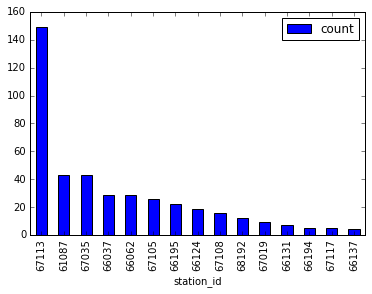

In [87]:
hotestStationDF.toPandas().set_index('station_id').plot(kind='bar')

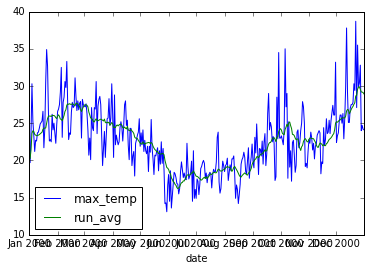

In [103]:

from pyspark.sql import Window
bomWithDateDF.where((col('station_id') == 66062) & (col('year') == 2000)) \
             .select(col('date'), col('max_temp'), avg(col('max_temp')) \
             .over(Window.orderBy(col('date')) \
                   .partitionBy(col('station_id')).rowsBetween(-14,Window.currentRow )).alias('run_avg')).sort('date')\
    .toPandas().set_index('date').plot()

### SQL

In [21]:
bomDF.registerTempTable('bom')

sql('SELECT COUNT(*) FROM bom')



,count(1)
0,352696


In [22]:
sql('''SELECT station_id, month, avg(max_temp) AS avg_max_temperature FROM bom
        WHERE year > 2000 GROUP by station_id, month ORDER BY station_id, month
    ''')

,station_id,month,avg_max_temperature
0,61087,1,28.214653
1,61087,2,27.224859
2,61087,3,25.806410
3,61087,4,23.452368
4,61087,5,20.520250
5,61087,6,18.490671
6,61087,7,17.728375
7,61087,8,19.595380
8,61087,9,22.388286
9,61087,10,23.844444
